In [12]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood, LeaveOneOutPseudoLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.priors import GammaPrior, LogNormalPrior
import gpytorch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement, qNoisyExpectedHypervolumeImprovement
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.box_decompositions import NondominatedPartitioning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list

from botorch.utils.transforms import unnormalize
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))


In [14]:
def x_normalizer(X, var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_norm

def x_denormalizer(x_norm, var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_original

def get_closest_value(given_value, array_list):
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    closest_value = min(array_list, key=absolute_difference_function)
    return closest_value
    
def get_closest_array(suggested_x, var_list):
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [15]:
def make_linspace(start, stop, step):
    num_points = int(round((stop - start) / step)) + 1
    return np.round(np.linspace(start, stop, num_points), 4)  # round for cleaner floats

speed_inorg_var   = make_linspace(0.25, 1.00, 0.01)  # m/min
speed_org_var     = make_linspace(0.25, 1.00, 0.01)  # m/min
inkFL_inorg_var   = make_linspace(80, 240, 1)       # uL/min
inkFL_org_var     = make_linspace(100, 280, 1)      # uL/min
conc_inorg_var    = make_linspace(0.8, 1.4, 0.05)     # M
conc_org_var      = make_linspace(0.4, 1.2, 0.05)     # M
humidity_var      = make_linspace(10, 45, 1)        # %RH
temp_var          = make_linspace(20, 50, 1)        # °C

# Tracking unique values
speed_inorg_num   = len(speed_inorg_var)
speed_org_num     = len(speed_org_var)
inkFL_inorg_num   = len(inkFL_inorg_var)
inkFL_org_num     = len(inkFL_org_var)
conc_inorg_num    = len(conc_inorg_var)
conc_org_num      = len(conc_org_var)
humidity_num      = len(humidity_var)
temp_num          = len(temp_var)

# Pack into var_array for downstream normalization
var_array = [speed_inorg_var, speed_org_var, 
             inkFL_inorg_var, inkFL_org_var,
             conc_inorg_var, conc_org_var,
             humidity_var, temp_var]

x_labels = ['Speed (Inorg) [m/min]', 'Speed (Org) [m/min]', 
            'inkFL (Inorg) [uL/min]', 'inkFL (Org) [uL/min]',
            'Conc. (Inorg) [M]', 'Conc. (Org) [M]',
            'RH [%]', 'Temp [C]']

In [16]:
# parameter_space = ParameterSpace([ContinuousParameter('x1', 0, 1),
#                                   ContinuousParameter('x2', 0, 1),
#                                   ContinuousParameter('x3', 0, 1),
#                                   ContinuousParameter('x4', 0, 1),
#                                   ContinuousParameter('x5', 0, 1),
#                                   ContinuousParameter('x6', 0, 1),
#                                   ContinuousParameter('x7', 0, 1),
#                                   ContinuousParameter('x8', 0, 1),
#                                  ])

## why is the parameter space different in the round 1 of the Joule code?

In [17]:
def check_clausius_clapeyron(humidity_vals, temp_vals):
    """
    Return boolean mask for valid points satisfying Clausius-Clapeyron constraints.
    Simplified: Ensures RH and Temp do not imply >100% saturation.
    """
    # Saturation vapor pressure approximation (T in Celsius)
    # Tetens formula: es(T) = 0.6108 * exp((17.27*T)/(T + 237.3)) [kPa]
    # RH = (actual / saturation) * 100
    # Check that vapor pressure does not exceed saturation vapor pressure
    valid_mask = []
    for RH, T in zip(humidity_vals, temp_vals):
        es = 0.6108 * np.exp((17.27 * T) / (T + 237.3))
        e = RH / 100.0 * es  # approximate check
        valid_mask.append(e <= es)
    return np.array(valid_mask)

In [18]:
#Load your real LHS experimental results (replace with real path)
dataset_final = pd.read_csv(r'batch0_results.csv')
#dataset_np = dataset_final.to_numpy()
#print(dataset_np)

#Extract input features (first 8 columns assumed to be process parameters) ===
X = dataset_final.iloc[:, 0:8].values  # shape: (8, 8)

#Extract targets
y = dataset_final[['PCE', 'Stability', 'Repeatability']].values  # shape: (8, 3)
#print(y)

#Standardize input and output
X_scaled = x_normalizer(X, var_array)
# Y_scaled = StandardScaler().fit_transform(y) ## is this the right way to normalize this? do i need to normalize this?
Y_max = np.max(y, axis=0)
Y_min = np.min(y, axis=0)
Y_scaled = (y - Y_min) / (Y_max - Y_min)
Y_scaled[:, 2] *= -1
#print(Y_scaled)

#Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_X = torch.tensor(X_scaled, dtype=torch.float64, device=device)
#print(train_X)
train_Y = torch.tensor(Y_scaled, dtype=torch.float64, device=device)
print(train_Y)

#Set seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)


tensor([[ 1.0000e+00,  1.0000e+00, -1.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00],
        [ 5.1613e-03,  0.0000e+00, -0.0000e+00],
        [ 5.5161e-01,  4.3535e-01, -5.0000e-01],
        [ 6.4516e-04,  0.0000e+00, -0.0000e+00],
        [ 7.8387e-01,  7.2913e-01, -3.0000e-01]], dtype=torch.float64)


In [19]:
dataset_final

,Speed (Inorg) [m/min],Speed (Org) [m/min],Pump rate (Inorg) [uL/min],Pump rate (Org) [uL/min],Conc. (Inorg) [M],Conc. (Org) [M],RH (Org) [%],Temp (Org) [C],PCE,Stability,Repeatability
0,0.30,0.30,82.5,120,1.40,0.40,12,23.0,15.50,12.22,2.0
1,0.58,0.30,190.0,134,0.85,0.75,14,24.7,0.00,0.00,0.0
2,0.95,0.58,170.0,246,0.90,0.85,30,44.0,0.00,0.00,0.0
3,0.67,0.95,150.0,179,1.05,1.15,17,31.8,0.00,0.00,0.0
4,0.77,0.39,130.0,269,1.15,0.65,23,28.5,0.08,0.00,0.0
5,0.39,0.67,230.0,201,1.20,0.55,27,41.6,8.55,5.32,1.0
6,0.30,0.86,90.0,224,1.30,0.95,35,41.6,0.01,0.00,0.0
7,0.86,0.48,210.0,111,1.35,1.05,38,36.3,12.15,8.91,0.6


In [20]:
def fit_gp_models(X, Y, kernel_fn=None, noise_prior=None):
    """
    Fits a list of GP models for each output dimension.
    Returns a ModelListGP.
    
    Args:
        X: torch tensor of shape (N, D)
        Y: torch tensor of shape (N, M)
        kernel_fn: function taking D and returning a GPyTorch kernel
        noise_prior: artificial noise to kernel

    Returns:
        model: ModelListGP with one GP per output
    """
    models = []
    for j in range(Y.shape[1]):
        covar_module = ScaleKernel(kernel_fn(X.shape[1])) if kernel_fn else RBFKernel(ard_num_dims = X.shape[1])
        likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior) if noise_prior else gpytorch.likelihoods.GaussianLikelihood()
        gp = SingleTaskGP(X, Y[:, j:j+1], covar_module=covar_module, likelihood=likelihood)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        #mll = LeaveOneOutPseudoLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        models.append(gp)
    return ModelListGP(*models)

# for i, gp in enumerate(gp_models):
#     ls = gp.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten()
#     print(f"Objective {i+1} lengthscales: {np.round(ls, 3)}")


In [21]:
matern_options = {
    "Matern_0.5": lambda d: MaternKernel(nu=0.5, ard_num_dims=d),
    "Matern_1.5": lambda d: MaternKernel(nu=1.5, ard_num_dims=d),
    "Matern_2.5": lambda d: MaternKernel(nu=2.5, ard_num_dims=d),
}

noise_options = {
    "None": None,
    "Gamma(1.1, 0.05)": GammaPrior(1.1, 0.05),
    "LogNormal(-4, 0.1)": LogNormalPrior(-4.0, 0.1),
}

In [22]:
# Grid search with LOO-CV
results = []
best_rmse = [np.inf] * train_Y.shape[1]
best_models = [None] * train_Y.shape[1]

for kernel_name, kernel_fn in matern_options.items():
    for noise_name, noise_prior in noise_options.items():
        preds_all = [[] for _ in range(train_Y.shape[1])]
        actuals_all = [[] for _ in range(train_Y.shape[1])]

        for i in range(train_X.shape[0]):
            X_cv = torch.cat([train_X[:i], train_X[i+1:]])
            Y_cv = torch.cat([train_Y[:i], train_Y[i+1:]])
            model_cv = fit_gp_models(X_cv, Y_cv, kernel_fn, noise_prior)

            for j, gp in enumerate(model_cv.models):
                pred = gp.posterior(train_X[i:i+1]).mean.item()
                preds_all[j].append(pred)
                actuals_all[j].append(train_Y[i, j].item())

        for j in range(train_Y.shape[1]):
            r2 = r2_score(actuals_all[j], preds_all[j])
            rmse = mean_squared_error(actuals_all[j], preds_all[j], squared=False)
            
            # Save best model for this objective
            if rmse < best_rmse[j]:
                best_rmse[j] = rmse
                model_j = fit_gp_models(train_X, train_Y, kernel_fn, noise_prior).models[j]
                best_models[j] = model_j


            results.append({
                "Kernel": kernel_name,
                "NoisePrior": noise_name,
                "Objective": ["PCE", "Stability", "Repeatability"][j],
                "R2": round(r2, 3),
                "RMSE": round(rmse, 3)
            })
            
model = ModelListGP(*best_models)

# Show results in a DataFrame
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will b

    Kernel         NoisePrior     Objective     R2  RMSE
Matern_0.5               None           PCE -1.516 0.623
Matern_0.5               None     Stability -1.661 0.615
Matern_0.5               None Repeatability -1.004 0.484
Matern_0.5   Gamma(1.1, 0.05)           PCE -1.475 0.618
Matern_0.5   Gamma(1.1, 0.05)     Stability -1.410 0.585
Matern_0.5   Gamma(1.1, 0.05) Repeatability -1.103 0.496
Matern_0.5 LogNormal(-4, 0.1)           PCE -1.518 0.623
Matern_0.5 LogNormal(-4, 0.1)     Stability -1.464 0.591
Matern_0.5 LogNormal(-4, 0.1) Repeatability -0.996 0.483
Matern_1.5               None           PCE -1.673 0.642
Matern_1.5               None     Stability -1.831 0.634
Matern_1.5               None Repeatability -1.551 0.546
Matern_1.5   Gamma(1.1, 0.05)           PCE -1.861 0.664
Matern_1.5   Gamma(1.1, 0.05)     Stability -1.540 0.600
Matern_1.5   Gamma(1.1, 0.05) Repeatability -1.645 0.556
Matern_1.5 LogNormal(-4, 0.1)           PCE -1.709 0.646
Matern_1.5 LogNormal(-4, 0.1)  

c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


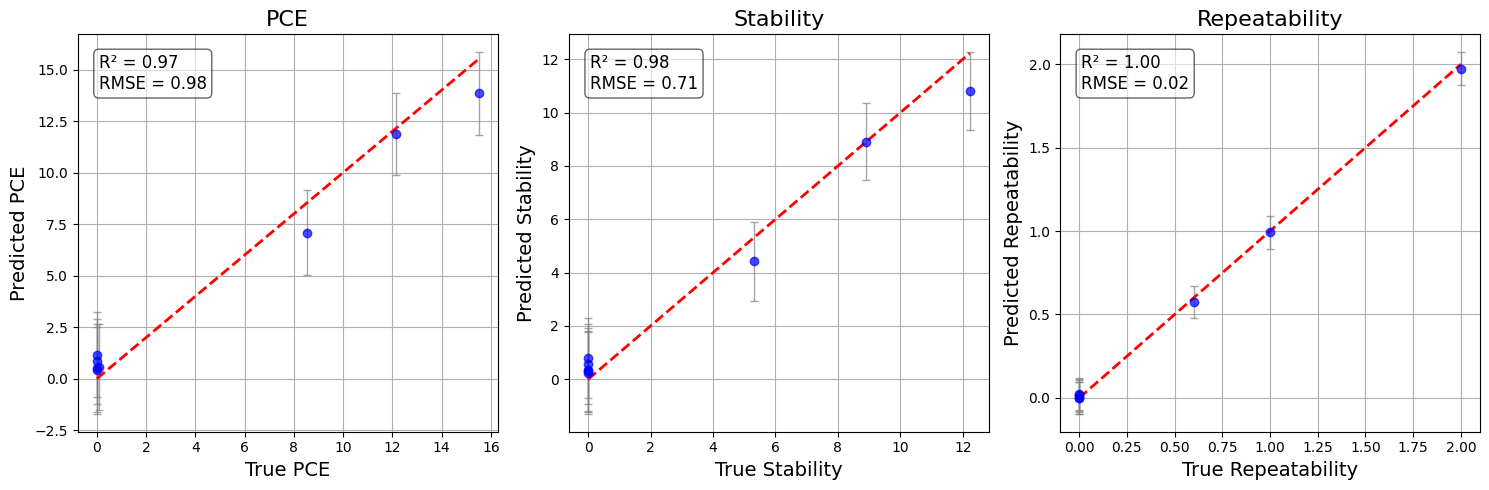

--- Model 1 (PCE) ---
Kernel: MaternKernel
Matern ν: 0.5
Noise prior: GammaPrior

--- Model 2 (Stability) ---
Kernel: MaternKernel
Matern ν: 0.5
Noise prior: GammaPrior

--- Model 3 (Repeatability) ---
Kernel: MaternKernel
Matern ν: 0.5
Noise prior: LogNormalPrior



In [23]:
# Evaluate posterior predictions on training data

posterior = model.posterior(train_X)
pred_std = torch.sqrt(posterior.variance).detach().cpu().numpy()
pred_mean = posterior.mean.detach().cpu().numpy()
true_Y = train_Y.detach().cpu().numpy()  # already scaled

# Reverse scaling
pred_mean_unnorm = pred_mean * (Y_max - Y_min) + Y_min
pred_std_unnorm = pred_std * (Y_max - Y_min)
true_mean_unnorm = true_Y * (Y_max - Y_min) + Y_min

# Flip repeatability back
pred_mean_unnorm[:, 2] *= -1
true_mean_unnorm[:, 2] *= -1


labels = ['PCE', 'Stability', 'Repeatability']
num_obj = train_Y.shape[1]

fig, axes = plt.subplots(1, num_obj, figsize=(5 * num_obj, 5))

for i in range(num_obj):
    ax = axes[i]

    # Compute metrics
    r2 = r2_score(true_mean_unnorm[:, i], pred_mean_unnorm[:, i])
    rmse = mean_squared_error(true_mean_unnorm[:, i], pred_mean_unnorm[:, i], squared=False)

    # Parity scatter with uncertainty bars
    ax.errorbar(
        true_mean_unnorm[:, i], pred_mean_unnorm[:, i],
        yerr=pred_std_unnorm[:, i],
        fmt='o', color='blue', ecolor='gray', elinewidth=1, capsize=3,
        alpha=0.7
    )

    # Parity line
    min_val = min(true_mean_unnorm[:, i].min(), pred_mean_unnorm[:, i].min())
    max_val = max(true_mean_unnorm[:, i].max(), pred_mean_unnorm[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    # Labels and metrics
    ax.set_xlabel('True ' + labels[i], fontsize=14)
    ax.set_ylabel('Predicted ' + labels[i], fontsize=14)
    ax.set_title(f'{labels[i]}', fontsize=16)
    ax.text(0.05, 0.95, f'R² = {r2:.2f}\nRMSE = {rmse:.2f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.6))

    ax.grid(True)

plt.tight_layout()
plt.show()

for i, gp in enumerate(model.models):
    print(f"--- Model {i+1} ({['PCE', 'Stability', 'Repeatability'][i]}) ---")
    # Kernel type
    kernel = gp.covar_module.base_kernel
    print("Kernel:", type(kernel).__name__)

    # Check Matern ν if it's a Matern kernel
    if hasattr(kernel, "nu"):
        print("Matern ν:", kernel.nu)

    # Noise prior info
    noise_prior = gp.likelihood.noise_covar.raw_noise_constraint.initial_value
    prior_type = type(gp.likelihood.noise_covar.noise_prior).__name__ if gp.likelihood.noise_covar.noise_prior else "None"
    print("Noise prior:", prior_type)
    
    # print("Lengthscales:", gp.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten())
    # print("Outputscale:", gp.covar_module.outputscale.item())
    # print("Noise:", gp.likelihood.noise.item())
    print()


c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


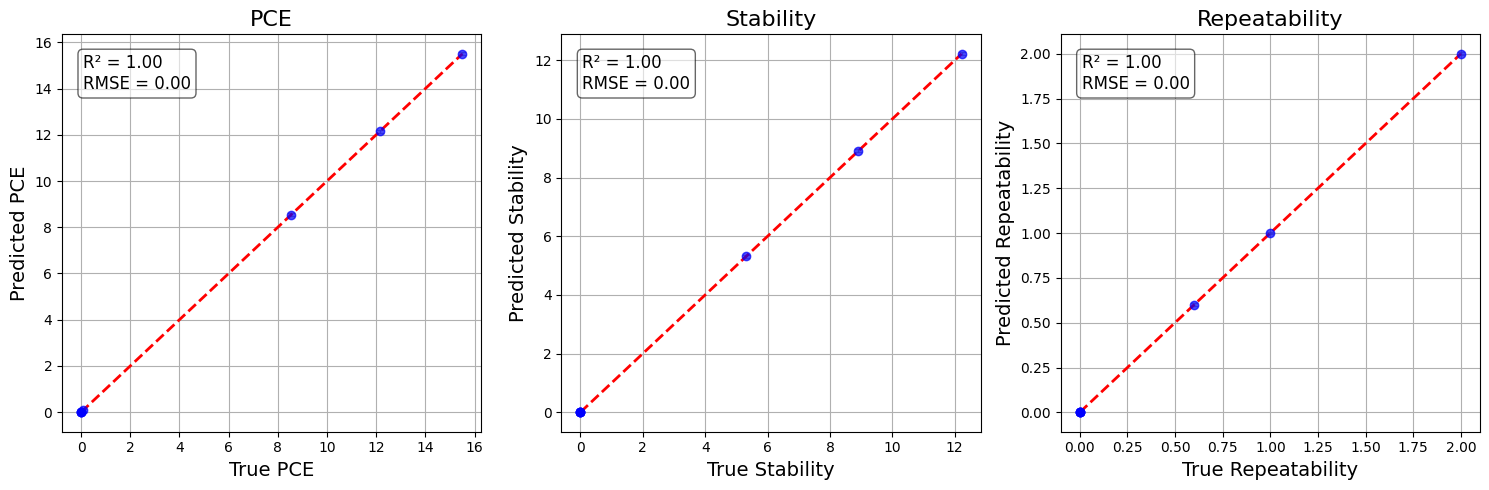

In [24]:
# --- Fit generic GP model with default settings ---
model_generic = fit_gp_models(train_X, train_Y)

# --- Posterior prediction ---
posterior_generic = model_generic.posterior(train_X)
pred_std_gen = torch.sqrt(posterior_generic.variance).detach().cpu().numpy()
pred_mean_gen = posterior_generic.mean.detach().cpu().numpy()
true_Y = train_Y.detach().cpu().numpy()

# --- Reverse scaling ---
pred_mean_unnorm_gen = pred_mean_gen * (Y_max - Y_min) + Y_min
pred_std_unnorm_gen = pred_std_gen * (Y_max - Y_min)
true_mean_unnorm = true_Y * (Y_max - Y_min) + Y_min

# --- Flip repeatability back ---
pred_mean_unnorm_gen[:, 2] *= -1
true_mean_unnorm[:, 2] *= -1

labels = ['PCE', 'Stability', 'Repeatability']
num_obj = train_Y.shape[1]

# --- Plot parity plots ---
fig, axes = plt.subplots(1, num_obj, figsize=(5 * num_obj, 5))
for i in range(num_obj):
    ax = axes[i]
    r2 = r2_score(true_mean_unnorm[:, i], pred_mean_unnorm_gen[:, i])
    rmse = mean_squared_error(true_mean_unnorm[:, i], pred_mean_unnorm_gen[:, i], squared=False)

    ax.errorbar(
        true_mean_unnorm[:, i], pred_mean_unnorm_gen[:, i],
        yerr=pred_std_unnorm_gen[:, i],
        fmt='o', color='blue', ecolor='gray', elinewidth=1, capsize=3, alpha=0.7
    )

    min_val = min(true_mean_unnorm[:, i].min(), pred_mean_unnorm_gen[:, i].min())
    max_val = max(true_mean_unnorm[:, i].max(), pred_mean_unnorm_gen[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    ax.set_xlabel('True ' + labels[i], fontsize=14)
    ax.set_ylabel('Predicted ' + labels[i], fontsize=14)
    ax.set_title(f'{labels[i]}', fontsize=16)
    ax.text(0.05, 0.95, f'R² = {r2:.2f}\nRMSE = {rmse:.2f}',
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor='white', alpha=0.6))
    ax.grid(True)

plt.tight_layout()
plt.show()

In [25]:
pareto_mask = is_non_dominated(train_Y)
pareto_Y = train_Y[pareto_mask]

ref_point = torch.tensor([-0.1, -0.1, -1.1], device=device) #
                        
hv = Hypervolume(ref_point=ref_point)
volume = hv.compute(pareto_Y)
print(train_Y)
print("Ref point:", ref_point)
print("Hypervolume:", volume)
print("Pareto size:", pareto_Y.shape[0])

tensor([[ 1.0000e+00,  1.0000e+00, -1.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00],
        [ 5.1613e-03,  0.0000e+00, -0.0000e+00],
        [ 5.5161e-01,  4.3535e-01, -5.0000e-01],
        [ 6.4516e-04,  0.0000e+00, -0.0000e+00],
        [ 7.8387e-01,  7.2913e-01, -3.0000e-01]], dtype=torch.float64)
Ref point: tensor([-0.1000, -0.1000, -1.1000])
Hypervolume: 0.6371472477912903
Pareto size: 3


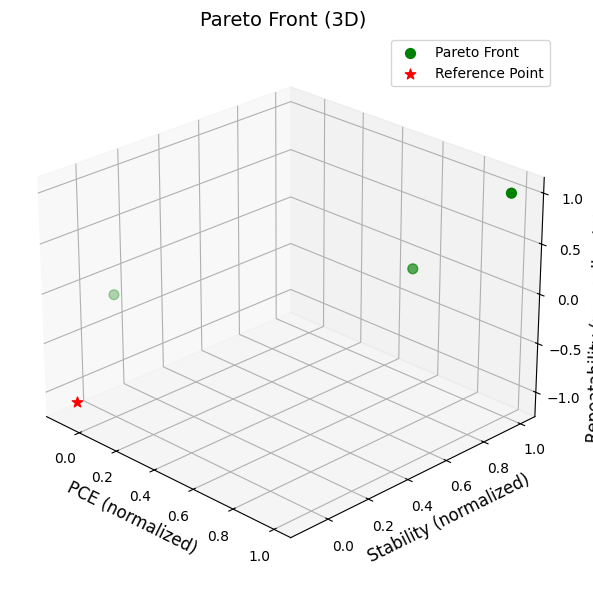

In [26]:
pareto_Y[:, 2] *= -1
pareto_Y_np = pareto_Y.detach().cpu().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot Pareto-optimal points
ax.scatter(pareto_Y_np[:, 0], pareto_Y_np[:, 1], pareto_Y_np[:, 2],
           c='green', s=50, label='Pareto Front', depthshade=True)

# Optionally, plot the reference point
ax.scatter([ref_point[0].item()], [ref_point[1].item()], [ref_point[2].item()],
           c='red', s=60, marker='*', label='Reference Point')

# Label axes
ax.set_xlabel('PCE (normalized)', fontsize=12)
ax.set_ylabel('Stability (normalized)', fontsize=12)
ax.set_zlabel('Repeatability (normalized, flipped)', fontsize=12)
ax.set_title('Pareto Front (3D)', fontsize=14)

ax.legend()
ax.view_init(elev=25, azim=-45)
plt.tight_layout()
plt.show()

In [27]:
acq_func = qNoisyExpectedHypervolumeImprovement(
    model=model,
    ref_point=ref_point,
    X_baseline=train_X,
    sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
    #eta=0.05,
    prune_baseline=False,
    alpha=0.0,
)

c:\Users\DanielAbdoue\anaconda3\envs\llms\Lib\site-packages\botorch\acquisition\multi_objective\monte_carlo.py:321: NumericsWarning: qNoisyExpectedHypervolumeImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qNoisyExpectedHypervolumeImprovement 	 --> 	 qLogNoisyExpectedHypervolumeImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [28]:
acq_func_gen = qNoisyExpectedHypervolumeImprovement(
    model=model_generic,
    ref_point=ref_point,
    X_baseline=train_X,
    sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
    #eta=0.05,
    prune_baseline=False,
    alpha=0.0,
)

In [29]:
NUM_RESTARTS = 20
RAW_SAMPLES = 512
BATCH_SIZE = 5
MAX_ATTEMPTS = 100

bounds = torch.tensor([[0.0] * 8, [1.0] * 8], device=device)

valid_candidates = None
valid_candidates_gen=None
attempts = 0

while attempts < MAX_ATTEMPTS:
    attempts += 1

    # Optimize acquisition function in normalized space
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={"batch_limit": 5, "maxiter": 200},
    )

    # Optimize acquisition function in normalized space for generic regressor
    candidates_gen, _ = optimize_acqf(
        acq_function=acq_func_gen,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={"batch_limit": 5, "maxiter": 200},
    )
    
    # Convert to original space and snap to valid grid
    X_cont = x_denormalizer(unnormalize(candidates, bounds).cpu().numpy(), var_array)
    X_snapped = get_closest_array(X_cont, var_array)

    # Convert generic to original space and snap to valid grid
    X_cont_gen = x_denormalizer(unnormalize(candidates_gen, bounds).cpu().numpy(), var_array)
    X_snapped_gen = get_closest_array(X_cont_gen, var_array)

    # Check Clausius-Clapeyron constraint
    RH_vals = X_snapped[:, 6]   # RH [%]
    Temp_vals = X_snapped[:, 7] # Temp [C]

    RH_vals_gen = X_snapped_gen[:, 6]   # RH [%]
    Temp_vals_gen = X_snapped_gen[:, 7] # Temp [C]
    
    cc_mask = check_clausius_clapeyron(RH_vals, Temp_vals)
    cc_mask_gen = check_clausius_clapeyron(RH_vals_gen, Temp_vals_gen)

    if cc_mask.all(): #i know this isn't great logic, but we never break cc relation; just benchmarking right now
        valid_candidates = X_snapped
        valid_candidates_gen = X_snapped_gen
        print(f"Found valid candidates after {attempts} attempts.")
        break

if valid_candidates is not None and valid_candidates_gen is not None:
    print("Final candidate batch:\n", valid_candidates)
    print("Final generic candidate batch:\n", valid_candidates_gen)
else:
    print("No valid batch found after max attempts.")

Found valid candidates after 1 attempts.
Final candidate batch:
 [[  0.33   0.63 202.   120.     1.4    0.8   38.    36.  ]
 [  0.39   0.7  116.   194.     0.95   1.1   22.    50.  ]
 [  0.78   0.78 150.   128.     1.4    0.7   37.    21.  ]
 [  0.8    0.37 107.   114.     1.4    0.7   42.    49.  ]
 [  0.39   0.82 108.   119.     1.4    1.2   29.    37.  ]]
Final generic candidate batch:
 [[  1.     1.   240.   100.     1.4    0.55  28.    45.  ]
 [  0.25   0.89 240.   100.     1.4    0.75  37.    48.  ]
 [  0.25   0.61 240.   143.     1.4    0.75  41.    45.  ]
 [  0.25   0.5  240.   100.     1.4    1.2   42.    28.  ]
 [  1.     0.62  93.   100.     1.4    0.7   16.    30.  ]]


In [30]:
print("Final candidate batch:\n", valid_candidates)
print("Final generic candidate batch:\n", valid_candidates_gen)

Final candidate batch:
 [[  0.33   0.63 202.   120.     1.4    0.8   38.    36.  ]
 [  0.39   0.7  116.   194.     0.95   1.1   22.    50.  ]
 [  0.78   0.78 150.   128.     1.4    0.7   37.    21.  ]
 [  0.8    0.37 107.   114.     1.4    0.7   42.    49.  ]
 [  0.39   0.82 108.   119.     1.4    1.2   29.    37.  ]]
Final generic candidate batch:
 [[  1.     1.   240.   100.     1.4    0.55  28.    45.  ]
 [  0.25   0.89 240.   100.     1.4    0.75  37.    48.  ]
 [  0.25   0.61 240.   143.     1.4    0.75  41.    45.  ]
 [  0.25   0.5  240.   100.     1.4    1.2   42.    28.  ]
 [  1.     0.62  93.   100.     1.4    0.7   16.    30.  ]]


In [31]:
# After optimizing
acq_val = acq_func(torch.tensor(x_normalizer(valid_candidates, var_array), dtype=torch.float64, device=device))
acq_val_gen = acq_func_gen(torch.tensor(x_normalizer(valid_candidates_gen, var_array), dtype=torch.float64, device=device))

# Random candidates
rand_X = torch.rand(BATCH_SIZE, train_X.shape[-1], device=device)
rand_acq_val = acq_func(rand_X)

print("Random candidate acquisition values:", rand_acq_val.detach().cpu().numpy())
print("Acquisition values of optimized suggested candidates:", acq_val.detach().cpu().numpy())
print("Acquisition values of generic suggested candidates:", acq_val_gen.detach().cpu().numpy())

Random candidate acquisition values: [0.06680807]
Acquisition values of optimized suggested candidates: [0.71814755]
Acquisition values of generic suggested candidates: [0.87936761]


In [32]:
X_new_scaled = torch.tensor(x_normalizer(valid_candidates, var_array), dtype=torch.float64, device=device)
X_new_scaled_gen = torch.tensor(x_normalizer(valid_candidates_gen, var_array), dtype=torch.float64, device=device)

posterior_new = model.posterior(X_new_scaled)
mean_new = posterior_new.mean.detach().cpu().numpy()
std_new = posterior_new.variance.sqrt().detach().cpu().numpy()
mean_new_unnorm = mean_new * (Y_max - Y_min) + Y_min
std_new_unnorm = std_new * (Y_max - Y_min)
mean_new_unnorm[:, 2] *= -1
#std_new_unnorm[:, 2] *= -1

posterior_new_gen = model_generic.posterior(X_new_scaled_gen)
mean_new_gen = posterior_new_gen.mean.detach().cpu().numpy()
std_new_gen = posterior_new_gen.variance.sqrt().detach().cpu().numpy()
mean_new_unnorm_gen = mean_new_gen * (Y_max - Y_min) + Y_min
std_new_unnorm_gen = std_new_gen * (Y_max - Y_min)
mean_new_unnorm_gen[:, 2] *= -1

columns = ['PCE', 'Stability', 'Repeatability']
results_df = pd.DataFrame(mean_new_unnorm, columns=[f'{col}_mean' for col in columns])
for i, col in enumerate(columns):
    results_df[f'{col}_std'] = std_new_unnorm[:, i]

results_df_gen = pd.DataFrame(mean_new_unnorm_gen, columns=[f'{col}_mean' for col in columns])
for i, col in enumerate(columns):
    results_df_gen[f'{col}_std'] = std_new_unnorm_gen[:, i]

# Add parameter values too
param_df = pd.DataFrame(valid_candidates, columns=x_labels)
full_results = pd.concat([param_df, results_df], axis=1)
#print(full_results.values.tolist())

param_df_gen = pd.DataFrame(valid_candidates_gen, columns=x_labels)
full_results_gen = pd.concat([param_df_gen, results_df_gen], axis=1)

In [33]:
full_results

,Speed (Inorg) [m/min],Speed (Org) [m/min],inkFL (Inorg) [uL/min],inkFL (Org) [uL/min],Conc. (Inorg) [M],Conc. (Org) [M],RH [%],Temp [C],PCE_mean,Stability_mean,Repeatability_mean,PCE_std,Stability_std,Repeatability_std
0,0.33,0.63,202.0,120.0,1.40,0.8,38.0,36.0,13.835161,10.805461,0.011249,1.995668,1.448653,0.328462
1,0.39,0.70,116.0,194.0,0.95,1.1,22.0,50.0,0.998174,0.581257,0.301986,4.303847,3.092262,0.328517
2,0.78,0.78,150.0,128.0,1.40,0.7,37.0,21.0,12.555681,9.809599,0.021751,3.081204,2.224454,0.328462
3,0.80,0.37,107.0,114.0,1.40,0.7,42.0,49.0,13.045992,10.143197,0.021751,2.710148,1.943229,0.328462
4,0.39,0.82,108.0,119.0,1.40,1.2,29.0,37.0,13.702589,10.693682,0.120536,2.148858,1.553111,0.429532


In [34]:
full_results_gen

,Speed (Inorg) [m/min],Speed (Org) [m/min],inkFL (Inorg) [uL/min],inkFL (Org) [uL/min],Conc. (Inorg) [M],Conc. (Org) [M],RH [%],Temp [C],PCE_mean,Stability_mean,Repeatability_mean,PCE_std,Stability_std,Repeatability_std
0,1.00,1.00,240.0,100.0,1.4,0.55,28.0,45.0,16.277262,12.442969,0.961563,2.732911,1.441516,0.398658
1,0.25,0.89,240.0,100.0,1.4,0.75,37.0,48.0,15.295002,11.592727,0.102330,1.997183,1.121230,0.146874
2,0.25,0.61,240.0,143.0,1.4,0.75,41.0,45.0,14.028107,9.997819,-0.012321,1.927016,1.176629,0.157741
3,0.25,0.50,240.0,100.0,1.4,1.20,42.0,28.0,11.838228,8.643336,-0.006143,1.253504,0.842705,0.348739
4,1.00,0.62,93.0,100.0,1.4,0.70,16.0,30.0,14.746607,11.529929,0.178020,1.590713,0.907575,0.269402


In [35]:
def compute_diversity_score(X: np.ndarray) -> float:
    """
    Computes the average pairwise Euclidean distance between rows in X.
    A higher value indicates greater diversity among candidate points.
    
    Args:
        X (np.ndarray): 2D array of shape (n_points, n_features)

    Returns:
        float: average pairwise distance
    """
    if len(X) < 2:
        return 0.0  # Not enough points to compute diversity
    distances = pdist(X, metric='euclidean')  # All pairwise distances
    return distances.mean()


In [36]:
diversity = compute_diversity_score(X_new_scaled.cpu().numpy())
diversity_gen = compute_diversity_score(X_new_scaled_gen.cpu().numpy())
print(f"Diversity score of batch: {diversity:.4f}")
print(f"Diversity score of generic batch: {diversity_gen:.4f}")

Diversity score of batch: 1.1270
Diversity score of generic batch: 1.2441


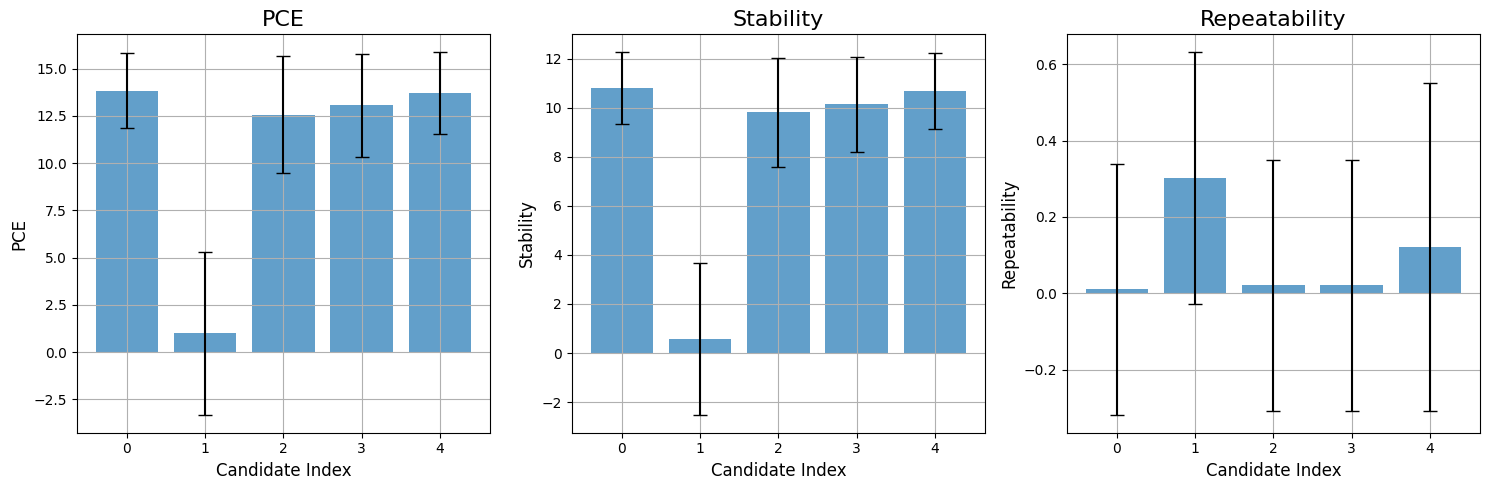

In [37]:
labels = ['PCE', 'Stability', 'Repeatability']
num_candidates = mean_new_unnorm.shape[0]
x = np.arange(num_candidates)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].bar(x, mean_new_unnorm[:, i], yerr=std_new_unnorm[:, i], capsize=5, alpha=0.7)
    axes[i].set_title(labels[i], fontsize=16)
    axes[i].set_xlabel('Candidate Index', fontsize=12)
    axes[i].set_ylabel(labels[i], fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

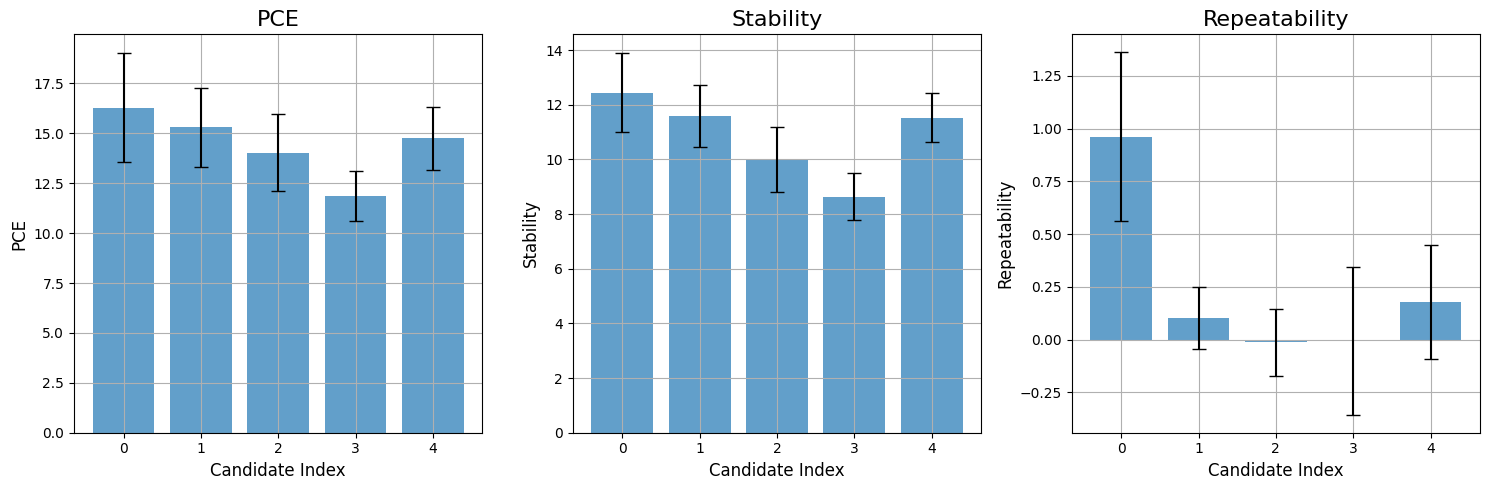

In [38]:
labels = ['PCE', 'Stability', 'Repeatability']
num_candidates_gen = mean_new_unnorm_gen.shape[0]
x = np.arange(num_candidates_gen)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].bar(x, mean_new_unnorm_gen[:, i], yerr=std_new_unnorm_gen[:, i], capsize=5, alpha=0.7)
    axes[i].set_title(labels[i], fontsize=16)
    axes[i].set_xlabel('Candidate Index', fontsize=12)
    axes[i].set_ylabel(labels[i], fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Updated Pareto front has 4 points
Hypervolume after batch: 1.0693
Volume Improvement of 0.4321362376213074
Max predicted PCE: 0.8927807277013518
Max predicted Stability: 0.8845114474690859
Max predicted Repeatability (flipped): -0.000995068222288925


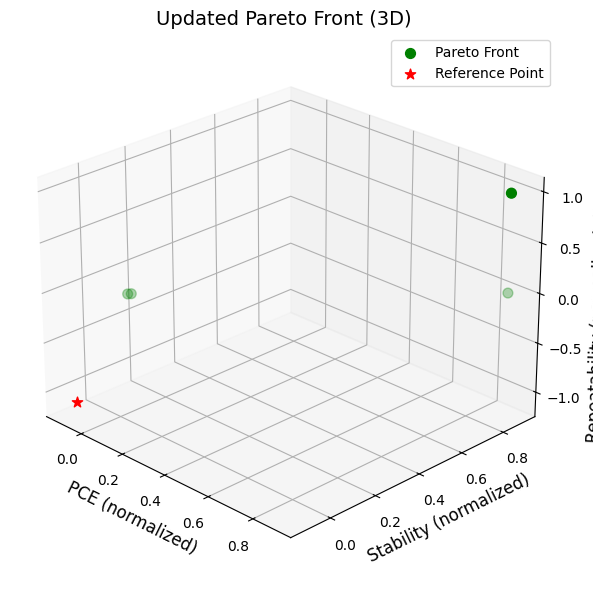

In [39]:
# Combine old and new predicted means (in normalized space)
pred_old = torch.tensor(pred_mean, dtype=torch.float64, device=device)
pred_new = torch.tensor(mean_new, dtype=torch.float64, device=device)

combined = torch.cat([pred_old, pred_new], dim=0)

# Define reference point and compute Pareto front
pareto_mask_combined = is_non_dominated(combined)
pareto_Y_combined = combined[pareto_mask_combined]

# Compute hypervolume
hv = Hypervolume(ref_point=ref_point)
hv_value = hv.compute(pareto_Y_combined)

print(f"Updated Pareto front has {pareto_Y_combined.shape[0]} points")
print(f"Hypervolume after batch: {hv_value:.4f}")
print(f"Volume Improvement of {hv_value - volume}")
print("Max predicted PCE:", combined[:, 0].max().item())
print("Max predicted Stability:", combined[:, 1].max().item())
print("Max predicted Repeatability (flipped):", combined[:, 2].max().item())



# Plot 3D Pareto front
pareto_Y_combined[:, 2] *= -1
pareto_Y_np = pareto_Y_combined.detach().cpu().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot Pareto-optimal points
ax.scatter(pareto_Y_np[:, 0], pareto_Y_np[:, 1], pareto_Y_np[:, 2],
           c='green', s=50, label='Pareto Front', depthshade=True)

# Plot the reference point
ax.scatter([ref_point[0].item()], [ref_point[1].item()], [ref_point[2].item()],
           c='red', s=60, marker='*', label='Reference Point')

# Labels
ax.set_xlabel('PCE (normalized)', fontsize=12)
ax.set_ylabel('Stability (normalized)', fontsize=12)
ax.set_zlabel('Repeatability (normalized, flipped)', fontsize=12)
ax.set_title('Updated Pareto Front (3D)', fontsize=14)

ax.legend()
ax.view_init(elev=25, azim=-45)
plt.tight_layout()
plt.show()


Updated Pareto front has 3 points
Hypervolume after batch: 1.3389
Volume Improvement of 0.7017763257026672
Max predicted PCE: 1.0501459395167578
Max predicted Stability: 1.018246263213575
Max predicted Repeatability (flipped): 0.0061603221396965835


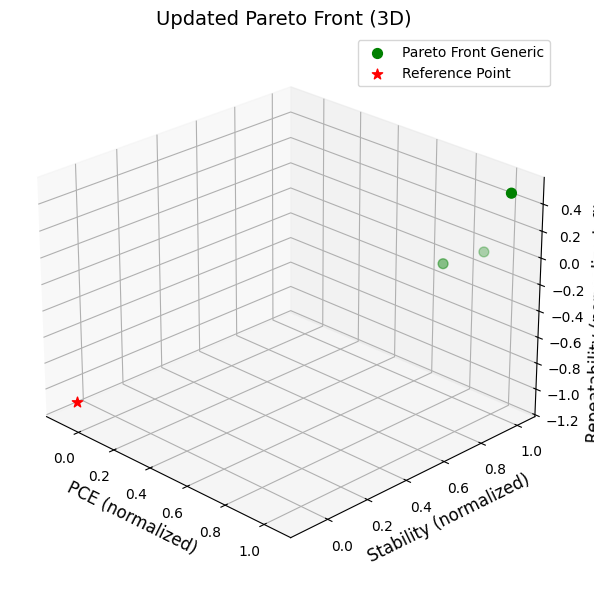

In [40]:
# Combine old and new predicted means (in normalized space)
pred_old = torch.tensor(pred_mean, dtype=torch.float64, device=device)
pred_new_gen = torch.tensor(mean_new_gen, dtype=torch.float64, device=device)

combined_gen = torch.cat([pred_old, pred_new_gen], dim=0)

# Define reference point and compute Pareto front
pareto_mask_combined_gen = is_non_dominated(combined_gen)
pareto_Y_combined_gen = combined_gen[pareto_mask_combined_gen]

# Compute hypervolume
hv = Hypervolume(ref_point=ref_point)
hv_value_gen = hv.compute(pareto_Y_combined_gen)

print(f"Updated Pareto front has {pareto_Y_combined_gen.shape[0]} points")
print(f"Hypervolume after batch: {hv_value_gen:.4f}")
print(f"Volume Improvement of {hv_value_gen - volume}")
print("Max predicted PCE:", combined_gen[:, 0].max().item())
print("Max predicted Stability:", combined_gen[:, 1].max().item())
print("Max predicted Repeatability (flipped):", combined_gen[:, 2].max().item())



# Plot 3D Pareto front
pareto_Y_combined_gen[:, 2] *= -1
pareto_Y_np_gen = pareto_Y_combined_gen.detach().cpu().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot Pareto-optimal points
ax.scatter(pareto_Y_np_gen[:, 0], pareto_Y_np_gen[:, 1], pareto_Y_np_gen[:, 2],
           c='green', s=50, label='Pareto Front Generic', depthshade=True)

# Plot the reference point
ax.scatter([ref_point[0].item()], [ref_point[1].item()], [ref_point[2].item()],
           c='red', s=60, marker='*', label='Reference Point')

# Labels
ax.set_xlabel('PCE (normalized)', fontsize=12)
ax.set_ylabel('Stability (normalized)', fontsize=12)
ax.set_zlabel('Repeatability (normalized, flipped)', fontsize=12)
ax.set_title('Updated Pareto Front (3D)', fontsize=14)

ax.legend()
ax.view_init(elev=25, azim=-45)
plt.tight_layout()
plt.show()


SHAP Analysis for Objective: PCE
Using all 8 points as background for SHAP explainer
Calculating SHAP values for all 8 points


  0%|          | 0/8 [00:00<?, ?it/s]

Calculated SHAP values for all objectives. Shape: (8, 8, 3)
  SHAP values for current objective (PCE): Shape (8, 8)
  Data shape for plot: (8, 8)
  Feature names: ['Speed (Inorg) [m/min]', 'Speed (Org) [m/min]', 'inkFL (Inorg) [uL/min]', 'inkFL (Org) [uL/min]', 'Conc. (Inorg) [M]', 'Conc. (Org) [M]', 'RH [%]', 'Temp [C]']


C:\Users\DanielAbdoue\AppData\Local\Temp\ipykernel_55740\2978661447.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


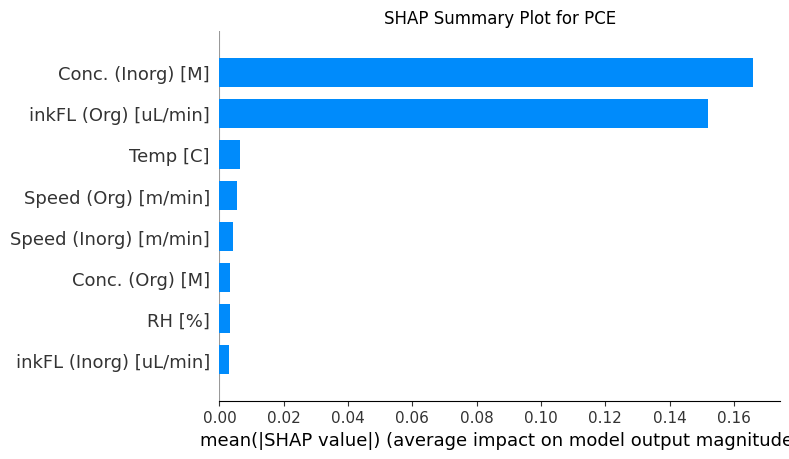

--------------------------------------------------

SHAP Analysis for Objective: Stability
Using all 8 points as background for SHAP explainer
Calculating SHAP values for all 8 points


  0%|          | 0/8 [00:00<?, ?it/s]

Calculated SHAP values for all objectives. Shape: (8, 8, 3)
  SHAP values for current objective (Stability): Shape (8, 8)
  Data shape for plot: (8, 8)
  Feature names: ['Speed (Inorg) [m/min]', 'Speed (Org) [m/min]', 'inkFL (Inorg) [uL/min]', 'inkFL (Org) [uL/min]', 'Conc. (Inorg) [M]', 'Conc. (Org) [M]', 'RH [%]', 'Temp [C]']


C:\Users\DanielAbdoue\AppData\Local\Temp\ipykernel_55740\2978661447.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


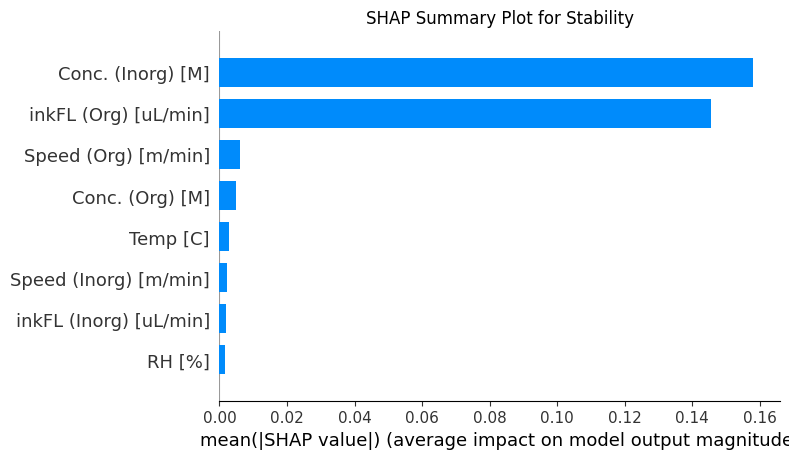

--------------------------------------------------

SHAP Analysis for Objective: Repeatability
Using all 8 points as background for SHAP explainer
Calculating SHAP values for all 8 points


  0%|          | 0/8 [00:00<?, ?it/s]

Calculated SHAP values for all objectives. Shape: (8, 8, 3)
  SHAP values for current objective (Repeatability): Shape (8, 8)
  Data shape for plot: (8, 8)
  Feature names: ['Speed (Inorg) [m/min]', 'Speed (Org) [m/min]', 'inkFL (Inorg) [uL/min]', 'inkFL (Org) [uL/min]', 'Conc. (Inorg) [M]', 'Conc. (Org) [M]', 'RH [%]', 'Temp [C]']


C:\Users\DanielAbdoue\AppData\Local\Temp\ipykernel_55740\2978661447.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


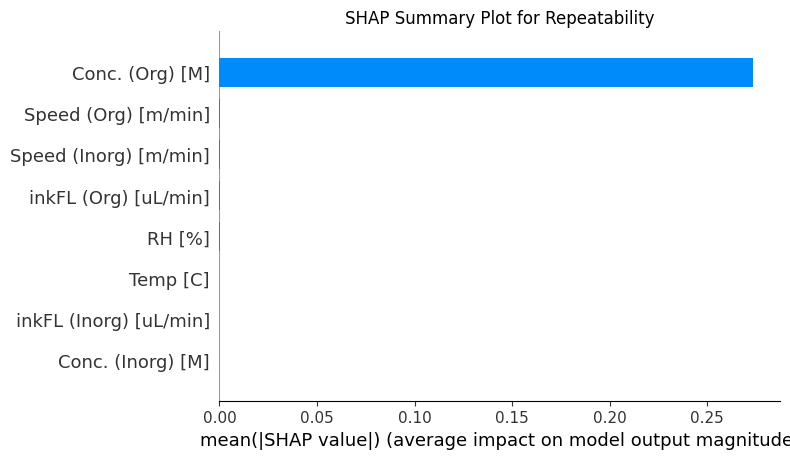

--------------------------------------------------



In [41]:
import shap
import matplotlib.pyplot as plt
import torch
import numpy as np

# Convert training data to numpy for SHAP
train_X_np = train_X.cpu().numpy()

# Ensure feature names are correctly defined
feature_names = x_labels

objective_names = ["PCE", "Stability", "Repeatability"]

for i, single_model in enumerate(best_models): # The variable 'i' will be 0, 1, 2
    print(f"SHAP Analysis for Objective: {objective_names[i]}")
    
    # Create a prediction function for the SHAP explainer
    def model_predict(X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        # Assuming 'model' is your global ModelListGP that predicts all 3 objectives
        posterior = model.posterior(X_tensor) 
        pred_mean = posterior.mean.detach().cpu().numpy()
        # pred_mean would be (number_of_X_samples, 3) for 3 objectives
        return pred_mean
    
    background_data = train_X_np
    print(f"Using all {train_X_np.shape[0]} points as background for SHAP explainer")
    
    explainer = shap.KernelExplainer(model_predict, background_data)

    samples_for_shap = train_X_np
    print(f"Calculating SHAP values for all {train_X_np.shape[0]} points")
    
    # Calculate SHAP values. If model_predict returns (N,3) for 3 objectives,
    # then 'all_objectives_shap_values' will be (num_samples, num_features, 3).
    # In your case, (8, 8, 3), as per your comment.
    all_objectives_shap_values = explainer.shap_values(samples_for_shap, nsamples=64)
    
    print(f"Calculated SHAP values for all objectives. Shape: {all_objectives_shap_values.shape}")
    
    # To iterate and get an (8,8) slice for each of the 3 objectives:
    shap_values_for_this_objective = all_objectives_shap_values[:, :, i]
    
    print(f"  SHAP values for current objective ({objective_names[i]}): Shape {shap_values_for_this_objective.shape}")
    print(f"  Data shape for plot: {samples_for_shap.shape}") # This is still (8,8)
    print(f"  Feature names: {feature_names}")
    
    # Plot the summary for the current objective using its 2D SHAP values
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_values_for_this_objective,  # Pass the 2D array for the specific objective
        samples_for_shap, 
        feature_names=feature_names,
        # class_names is not needed when plotting SHAP values for a single output/objective
        plot_type="bar",
        show=False
    )
    plt.title(f'SHAP Summary Plot for {objective_names[i]}') 
    plt.tight_layout()
    plt.savefig(f'shap_summary_{objective_names[i]}.png', dpi=300)
    plt.show()

    print("-" * 50 + "\n")